<div align="center">

<h1 align="center">✨ Elmer Andrés Collanqui Casapia ✨</h1>

<p>
💻 Ingeniería en Sistemas e Informática <br>
🚀 Aimara Lab<br>
📍 Universidad Nacional de Moquegua
</p>

<p>
✉️ Contacto: <a href="mailto:ecollanqui@aimaralab.com">ecollanqui@aimaralab.com</a> <br>
🌐 <a href="https://github.com/Mermas-CC" target="_blank">GitHub</a> | <a href="https://www.linkedin.com/in/elmer-andres-collanqui-casapia-977325315" target="_blank">LinkedIn</a>
</p>

<hr width="60%">


</div>


# ------------ Setup ------------

In [1]:
# Standard library
import os
import random
from glob import glob
import time

# Data & computation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Utilities
from tqdm.auto import tqdm
import kagglehub

# Configuración global
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
dataset_name = "kmader/skin-cancer-mnist-ham10000"
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# Selección de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Dispositivo seleccionado: {device}")

✅ Dispositivo seleccionado: cuda


# ------------ Datos ------------

In [2]:
# 📥 Carga de datos desde Kaggle Hub
print("\nDescargando el dataset...")
try:
    path = kagglehub.dataset_download(dataset_name)
    print(f"✅ Dataset descargado. Path: {path}")
except Exception as e:
    print(f"❌ Error al descargar el dataset: {e}")

# Carga la metadata
metadata = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))
print(f"✅ Metadata cargada: {len(metadata)} muestras")

# Mapea los IDs de las imágenes a las rutas de los archivos
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join(path, '**', '*.jpg'), recursive=True)}

# Añade las etiquetas y las rutas al dataframe de metadata
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
metadata['path'] = metadata['image_id'].map(image_path.get)

# Verifica la distribución de las clases antes de la división
print("\n🔍 Distribución de clases original:")
print(metadata['label'].value_counts().sort_index())

# ✂️ Particiones estratificadas (entrenamiento, validación, prueba)
train_df, test_df = train_test_split(
    metadata,
    test_size=0.2,
    random_state=42,
    stratify=metadata['label']
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=42,
    stratify=train_df['label']
)

print(f"\n📊 Tamaños de los conjuntos después de la división:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(val_df)} muestras")
print(f"Prueba: {len(test_df)} muestras")

# ⚖️ Balanceo del conjunto de entrenamiento
data_aug_rate = [15, 10, 5, 50, 5, 1, 40]

def balance_training_data(train_df, data_aug_rate):
    """Balancea el conjunto de entrenamiento duplicando las clases minoritarias."""
    balanced_dfs = []
    for class_idx, rate in enumerate(data_aug_rate):
        class_df = train_df[train_df['label'] == class_idx]
        if len(class_df) > 0 and rate > 0:
            augmented_df = pd.concat([class_df] * rate, ignore_index=True)
            balanced_dfs.append(augmented_df)
    return pd.concat(balanced_dfs, ignore_index=True)

train_df_balanced = balance_training_data(train_df, data_aug_rate)
print(f"\n✅ Conjunto de entrenamiento balanceado. Total: {len(train_df_balanced)} muestras")
print(train_df_balanced['label'].value_counts().sort_index())


Descargando el dataset...
✅ Dataset descargado. Path: /kaggle/input/skin-cancer-mnist-ham10000
✅ Metadata cargada: 10015 muestras

🔍 Distribución de clases original:
label
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
Name: count, dtype: int64

📊 Tamaños de los conjuntos después de la división:
Entrenamiento: 6009 muestras
Validación: 2003 muestras
Prueba: 2003 muestras

✅ Conjunto de entrenamiento balanceado. Total: 23543 muestras
label
0    2955
1    3080
2    3295
3    3450
4    3340
5    4023
6    3400
Name: count, dtype: int64


# ------------ Preprocesamiento ------------

In [3]:
# 🖼️ Clase Dataset personalizada
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_paths = dataframe['path'].values
        self.labels = dataframe['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# 🛠️ Transformaciones de datos
train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# ⚡ Creación de DataLoaders
train_dataset = SkinDataset(train_df_balanced, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print("✅ DataLoaders creados.")

✅ DataLoaders creados.


# ------------ Entrenamiento ResNet50 / Efficientnetb0 / MobileNetV2 ------------



<div align="center">
<p align="justify" style="max-width: 600px;">

-Los modelos fueron entrenados en tres cuadernos distintos, pero posteriormente se copiaron las celdas al formato solicitado.

-No se guardaron los valores de las épocas de entrenamiento, por lo que se construyó un arreglo con los valores impresos durante la ejecución.
Esto permitió evitar reentrenar los modelos y generar los gráficos de <i>accuracy</i> y <i>loss</i> a partir de dichos valores.

-Los entrenamientos lanzan los mensajes de "num_workers", lo que hace que los valores de los entrenamientos se vean separados, pero el entrenamiento final luego del early stoping esta al final de la celda
</p>

</div>


##Entrenamiento resnet50

In [5]:
# ⚙️ Funciones de modelo y entrenamiento
def create_model(model_name):
    """Crea una instancia de un modelo preentrenado y lo modifica para 7 clases."""
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(num_features, len(label_names))
        )
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(label_names))
    elif model_name == 'efficientnetb0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(label_names))
    else:
        raise ValueError("Modelo no soportado.")
    return model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=10):
    """Bucle de entrenamiento y validación del modelo con métricas detalladas."""
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    print(f"🚀 Iniciando entrenamiento de {model.__class__.__name__}...")
    for epoch in range(num_epochs):
        # Fase de entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Entrenamiento]')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (progress_bar.n + 1)
            current_acc = (train_correct / train_total) * 100
            progress_bar.set_postfix({
                'pérdida': f'{current_loss:.4f}',
                'precisión': f'{current_acc:.2f}%'
            })

        # Fase de validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Cálculo de métricas
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = (train_correct / train_total) * 100
        val_acc = (val_correct / val_total) * 100

        # Formato de impresión simplificado
        print(f'loss: {train_loss_avg:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc:.2f}%')

        # Verificación de Early Stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print('✓ Mejora en la pérdida de validación. Modelo actualizado.')
        else:
            patience_counter += 1
            print(f'Sin mejora. Paciencia: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print(f'⏹️ Early stopping activado. Se detiene el entrenamiento.')
                break

    # Cargar el mejor modelo para la evaluación final
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'✅ Mejor modelo de la época {best_epoch} cargado.')
    return model


# 🏋️‍♂️ Entrenamiento de ResNet50
resnet_model = create_model('resnet50') # Aquí se crea la instancia del modelo
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)
resnet_model = train_model(resnet_model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)

🚀 Iniciando entrenamiento de ResNet...


Época 1/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.6287 - accuracy: 76.49% - val_loss: 0.6984 - val_accuracy: 73.14%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 2/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.3468 - accuracy: 87.03% - val_loss: 0.6088 - val_accuracy: 79.78%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 3/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.2637 - accuracy: 90.08% - val_loss: 0.6921 - val_accuracy: 72.04%
Sin mejora. Paciencia: 1/5


Época 4/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.1996 - accuracy: 92.57% - val_loss: 0.6212 - val_accuracy: 82.13%
Sin mejora. Paciencia: 2/5


Época 5/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.1746 - accuracy: 93.61% - val_loss: 0.7372 - val_accuracy: 75.49%
Sin mejora. Paciencia: 3/5


Época 6/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b15b5f31f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^ ^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b15b5f31f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

loss: 0.1494 - accuracy: 94.60% - val_loss: 0.6720 - val_accuracy: 79.78%
Sin mejora. Paciencia: 4/5


Época 7/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b15b5f31f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b15b5f31f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

loss: 0.1386 - accuracy: 95.01% - val_loss: 0.6957 - val_accuracy: 79.18%
Sin mejora. Paciencia: 5/5
⏹️ Early stopping activado. Se detiene el entrenamiento.
✅ Mejor modelo de la época 2 cargado.


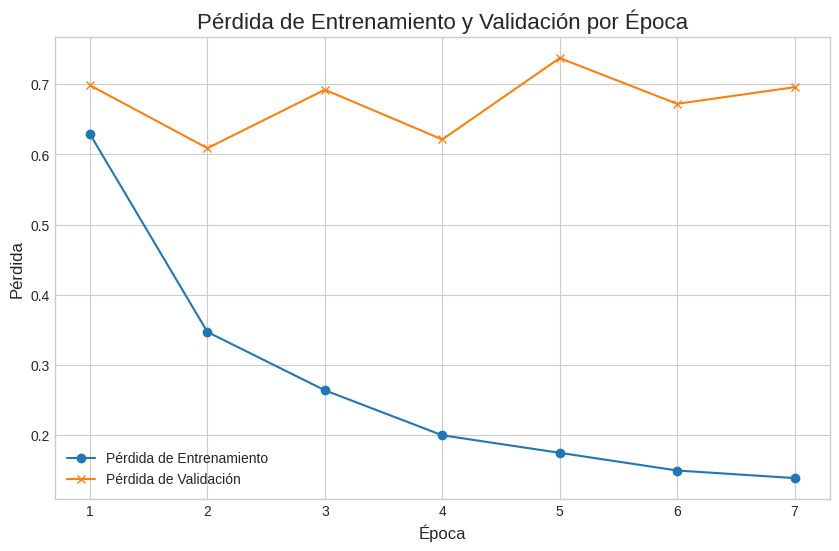

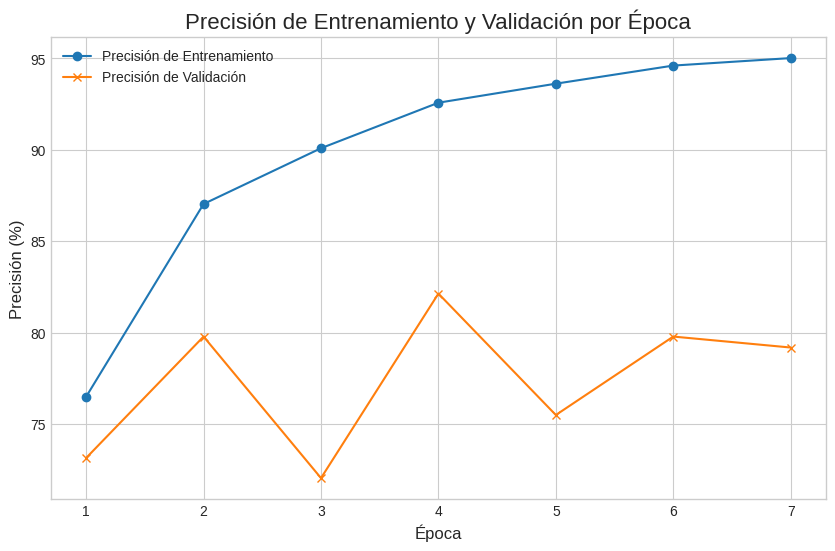

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos de las métricas de entrenamiento
data = {
    'epochs': [1, 2, 3, 4, 5, 6, 7],
    'loss': [0.6287, 0.3468, 0.2637, 0.1996, 0.1746, 0.1494, 0.1386],
    'accuracy': [76.49, 87.03, 90.08, 92.57, 93.61, 94.60, 95.01],
    'val_loss': [0.6984, 0.6088, 0.6921, 0.6212, 0.7372, 0.6720, 0.6957],
    'val_accuracy': [73.14, 79.78, 72.04, 82.13, 75.49, 79.78, 79.18]
}

# Crear un DataFrame de pandas para facilitar el manejo de los datos
df = pd.DataFrame(data)

# Configurar el estilo de los gráficos
plt.style.use('seaborn-v0_8-whitegrid')

# ----- Gráfico 1: Pérdida (Loss) vs. Épocas -----
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['loss'], label='Pérdida de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_loss'], label='Pérdida de Validación', marker='x')
plt.title('Pérdida de Entrenamiento y Validación por Época', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.show()

# ----- Gráfico 2: Precisión (Accuracy) vs. Épocas -----
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['accuracy'], label='Precisión de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_accuracy'], label='Precisión de Validación', marker='x')
plt.title('Precisión de Entrenamiento y Validación por Época', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.show()

##Entrenamiento efficientnetb0

In [ ]:
# ⚙️ Funciones de modelo y entrenamiento
def create_model(model_name):
    """Crea una instancia de un modelo preentrenado y lo modifica para 7 clases."""
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(num_features, len(label_names))
        )
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(label_names))
    elif model_name == 'efficientnetb0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(label_names))
    else:
        raise ValueError("Modelo no soportado.")
    return model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=10):
    """Bucle de entrenamiento y validación del modelo con métricas detalladas."""
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    print(f"🚀 Iniciando entrenamiento de {model.__class__.__name__}...")
    for epoch in range(num_epochs):
        # Fase de entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Entrenamiento]')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (progress_bar.n + 1)
            current_acc = (train_correct / train_total) * 100
            progress_bar.set_postfix({
                'pérdida': f'{current_loss:.4f}',
                'precisión': f'{current_acc:.2f}%'
            })

        # Fase de validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Cálculo de métricas
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = (train_correct / train_total) * 100
        val_acc = (val_correct / val_total) * 100

        # Formato de impresión simplificado
        print(f'loss: {train_loss_avg:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc:.2f}%')

        # Verificación de Early Stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print('✓ Mejora en la pérdida de validación. Modelo actualizado.')
        else:
            patience_counter += 1
            print(f'Sin mejora. Paciencia: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print(f'⏹️ Early stopping activado. Se detiene el entrenamiento.')
                break

    # Cargar el mejor modelo para la evaluación final
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'✅ Mejor modelo de la época {best_epoch} cargado.')
    return model

# 🏋️‍♂️ Entrenamiento de EfficientNetB0
efficientnet_model = create_model('efficientnetb0') # Y aquí se cambia de nuevo
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-5)
efficientnet_model = train_model(efficientnet_model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 128MB/s]


🚀 Iniciando entrenamiento de EfficientNet...


Época 1/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.5316 - accuracy: 80.48% - val_loss: 0.6273 - val_accuracy: 75.24%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 2/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.2465 - accuracy: 90.94% - val_loss: 0.5603 - val_accuracy: 80.93%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 3/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>^

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
can only test a child process    
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

loss: 0.1668 - accuracy: 93.88% - val_loss: 0.6093 - val_accuracy: 80.58%
Sin mejora. Paciencia: 1/5


Época 4/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

loss: 0.1290 - accuracy: 95.40% - val_loss: 0.6132 - val_accuracy: 85.12%
Sin mejora. Paciencia: 2/5


Época 5/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
            ^^ ^^^^^^^^^^^^^Exception ignored in: ^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>^

^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/uti

loss: 0.1145 - accuracy: 95.98% - val_loss: 0.6254 - val_accuracy: 84.82%
Sin mejora. Paciencia: 3/5


Época 6/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.1001 - accuracy: 96.47% - val_loss: 0.5155 - val_accuracy: 86.17%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 7/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.0764 - accuracy: 97.38% - val_loss: 0.5888 - val_accuracy: 86.07%
Sin mejora. Paciencia: 1/5


Época 8/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.0745 - accuracy: 97.47% - val_loss: 0.6085 - val_accuracy: 83.62%
Sin mejora. Paciencia: 2/5


Época 9/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.0674 - accuracy: 97.67% - val_loss: 0.6325 - val_accuracy: 86.22%
Sin mejora. Paciencia: 3/5


Época 10/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.0640 - accuracy: 97.69% - val_loss: 0.7171 - val_accuracy: 82.98%
Sin mejora. Paciencia: 4/5


Época 11/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.0567 - accuracy: 97.98% - val_loss: 0.7605 - val_accuracy: 84.97%
Sin mejora. Paciencia: 5/5
⏹️ Early stopping activado. Se detiene el entrenamiento.
✅ Mejor modelo de la época 6 cargado.


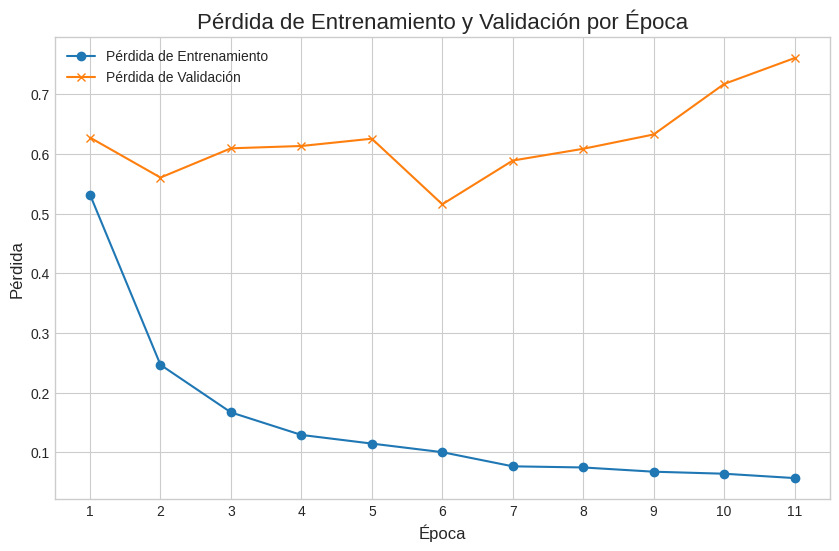

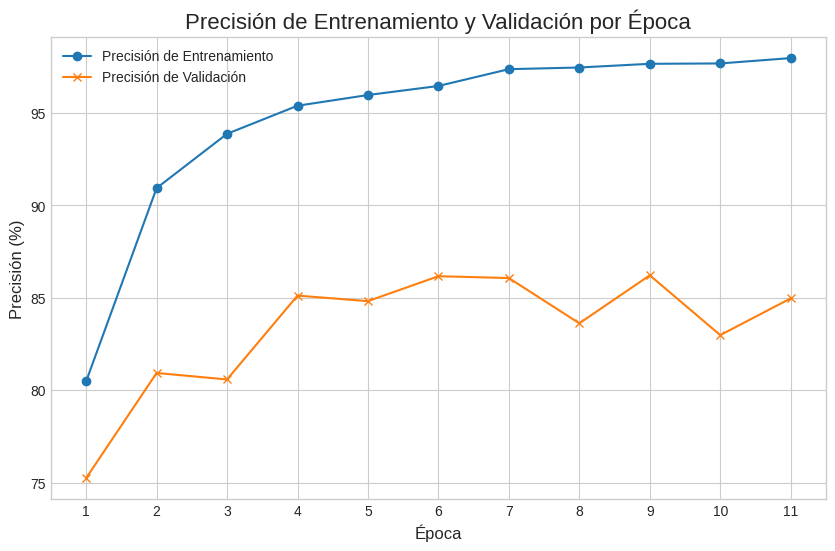

In [ ]:
import matplotlib.pyplot as plt

# Datos de las métricas de entrenamiento
training_loss = [0.5316, 0.2465, 0.1668, 0.1290, 0.1145, 0.1001, 0.0764, 0.0745, 0.0674, 0.0640, 0.0567]
training_accuracy = [80.48, 90.94, 93.88, 95.40, 95.98, 96.47, 97.38, 97.47, 97.67, 97.69, 97.98]

# Datos de las métricas de validación
validation_loss = [0.6273, 0.5603, 0.6093, 0.6132, 0.6254, 0.5155, 0.5888, 0.6085, 0.6325, 0.7171, 0.7605]
validation_accuracy = [75.24, 80.93, 80.58, 85.12, 84.82, 86.17, 86.07, 83.62, 86.22, 82.98, 84.97]

# Generar el array de épocas
epochs = range(1, len(training_loss) + 1)

# Configurar el estilo de los gráficos
plt.style.use('seaborn-v0_8-whitegrid')

# ----- Gráfico 1: Pérdida (Loss) vs. Épocas -----
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Pérdida de Entrenamiento', marker='o')
plt.plot(epochs, validation_loss, label='Pérdida de Validación', marker='x')
plt.title('Pérdida de Entrenamiento y Validación por Época', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.legend()
plt.xticks(epochs)
plt.grid(True)
plt.show()

# ----- Gráfico 2: Precisión (Accuracy) vs. Épocas -----
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label='Precisión de Entrenamiento', marker='o')
plt.plot(epochs, validation_accuracy, label='Precisión de Validación', marker='x')
plt.title('Precisión de Entrenamiento y Validación por Época', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.legend()
plt.xticks(epochs)
plt.grid(True)
plt.show()

##Entrenamiento mobilenetv2

In [ ]:
# ⚙️ Funciones de modelo y entrenamiento
def create_model(model_name):
    """Crea una instancia de un modelo preentrenado y lo modifica para 7 clases."""
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(num_features, len(label_names))
        )
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(label_names))
    elif model_name == 'efficientnetb0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, len(label_names))
    else:
        raise ValueError("Modelo no soportado.")
    return model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=10):
    """Bucle de entrenamiento y validación del modelo con métricas detalladas."""
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    print(f"🚀 Iniciando entrenamiento de {model.__class__.__name__}...")
    for epoch in range(num_epochs):
        # Fase de entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Entrenamiento]')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (progress_bar.n + 1)
            current_acc = (train_correct / train_total) * 100
            progress_bar.set_postfix({
                'pérdida': f'{current_loss:.4f}',
                'precisión': f'{current_acc:.2f}%'
            })

        # Fase de validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Cálculo de métricas
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = (train_correct / train_total) * 100
        val_acc = (val_correct / val_total) * 100

        # Formato de impresión simplificado
        print(f'loss: {train_loss_avg:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc:.2f}%')

        # Verificación de Early Stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print('✓ Mejora en la pérdida de validación. Modelo actualizado.')
        else:
            patience_counter += 1
            print(f'Sin mejora. Paciencia: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print(f'⏹️ Early stopping activado. Se detiene el entrenamiento.')
                break

    # Cargar el mejor modelo para la evaluación final
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'✅ Mejor modelo de la época {best_epoch} cargado.')
    return model

# 🏋️‍♂️ Entrenamiento de MobileNetV2
mobilenet_model = create_model('mobilenetv2')
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001, weight_decay=1e-5)
mobilenet_model = train_model(mobilenet_model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)

🚀 Iniciando entrenamiento de MobileNetV2...


Época 1/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.5719 - accuracy: 78.84% - val_loss: 0.8493 - val_accuracy: 69.75%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 2/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.2886 - accuracy: 89.36% - val_loss: 0.5671 - val_accuracy: 80.23%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 3/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.2136 - accuracy: 92.08% - val_loss: 0.5586 - val_accuracy: 83.03%
✓ Mejora en la pérdida de validación. Modelo actualizado.


Época 4/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.1716 - accuracy: 93.66% - val_loss: 0.6529 - val_accuracy: 80.13%
Sin mejora. Paciencia: 1/5


Época 5/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.1331 - accuracy: 95.20% - val_loss: 0.6193 - val_accuracy: 83.67%
Sin mejora. Paciencia: 2/5


Época 6/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

loss: 0.1221 - accuracy: 95.51% - val_loss: 0.7864 - val_accuracy: 80.28%
Sin mejora. Paciencia: 3/5


Época 7/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e217cd35f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e217cd35f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

loss: 0.1025 - accuracy: 96.35% - val_loss: 0.6079 - val_accuracy: 84.52%
Sin mejora. Paciencia: 4/5


Época 8/30 [Entrenamiento]:   0%|          | 0/184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e217cd35f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e217cd35f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

loss: 0.0997 - accuracy: 96.45% - val_loss: 0.6263 - val_accuracy: 84.07%
Sin mejora. Paciencia: 5/5
⏹️ Early stopping activado. Se detiene el entrenamiento.
✅ Mejor modelo de la época 3 cargado.


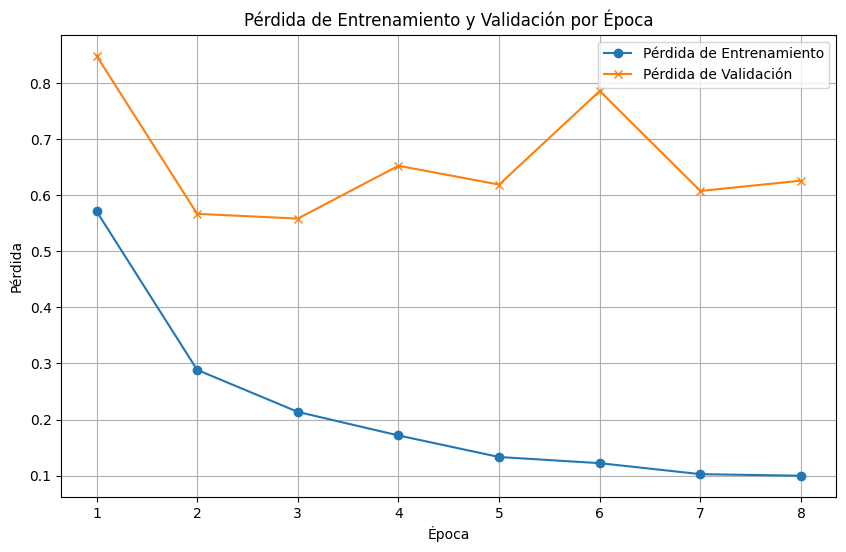

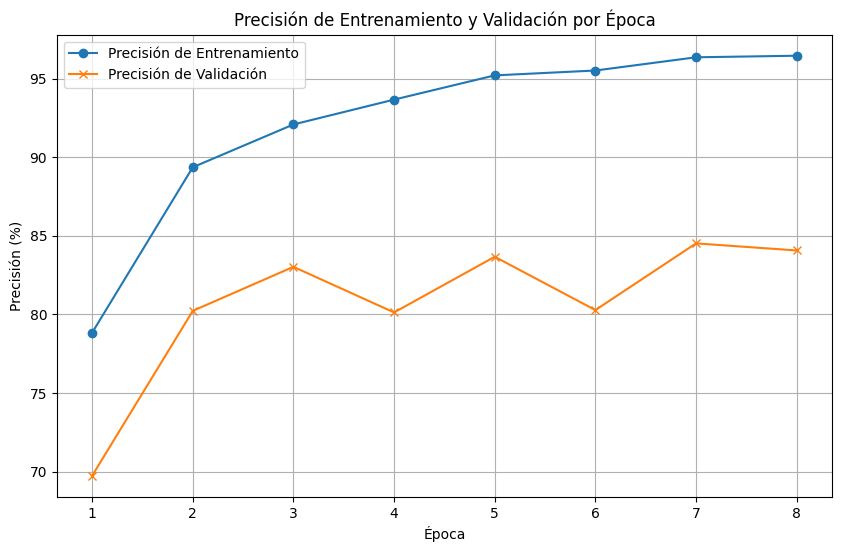

In [ ]:
import matplotlib.pyplot as plt

# Datos de la pérdida de entrenamiento
training_loss = [0.5719, 0.2886, 0.2136, 0.1716, 0.1331, 0.1221, 0.1025, 0.0997]

# Datos de la precisión de entrenamiento
training_accuracy = [78.84, 89.36, 92.08, 93.66, 95.20, 95.51, 96.35, 96.45]

# Datos de la pérdida de validación
validation_loss = [0.8493, 0.5671, 0.5586, 0.6529, 0.6193, 0.7864, 0.6079, 0.6263]

# Datos de la precisión de validación
validation_accuracy = [69.75, 80.23, 83.03, 80.13, 83.67, 80.28, 84.52, 84.07]

# Generar el array de épocas
epochs = range(1, len(training_loss) + 1)

# --- Gráfico 1: Pérdida (Loss) vs. Épocas ---
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Pérdida de Entrenamiento', marker='o')
plt.plot(epochs, validation_loss, label='Pérdida de Validación', marker='x')
plt.title('Pérdida de Entrenamiento y Validación por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.xticks(epochs)
plt.grid(True)
plt.savefig('grafico_perdida.png')
plt.show()

# --- Gráfico 2: Precisión (Accuracy) vs. Épocas ---
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label='Precisión de Entrenamiento', marker='o')
plt.plot(epochs, validation_accuracy, label='Precisión de Validación', marker='x')
plt.title('Precisión de Entrenamiento y Validación por Época')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()
plt.xticks(epochs)
plt.grid(True)
plt.savefig('grafico_precision.png')
plt.show()

# ------------ Evaluación ------------


<div align="center">
<p align="justify" style="max-width: 600px;">


-Las celdas dan un mensaje lardo de los "num_workers" y los resultados (metricas), estan al final
</p>

</div>



##ResNet50

Evaluando el modelo:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b15b5f31f80>Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b15b5f31f80>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
           ^^if w.is_alive():^^
  ^ ^^^ ^^^ ^^ ^ ^^^^^^^^^^^

--- Reporte de Clasificación Final ---
              precision    recall  f1-score   support

       akiec       0.81      0.60      0.69        65
         bcc       0.92      0.76      0.83       103
         bkl       0.74      0.65      0.70       220
          df       0.35      0.78      0.49        23
         mel       0.51      0.74      0.61       223
          nv       0.92      0.88      0.90      1341
        vasc       0.89      0.89      0.89        28

    accuracy                           0.82      2003
   macro avg       0.74      0.76      0.73      2003
weighted avg       0.85      0.82      0.83      2003


--- Métricas Macro ---
F1 Macro: 0.7290
Precision Macro: 0.7367
Recall Macro: 0.7577
ROC-AUC Macro: 0.9643


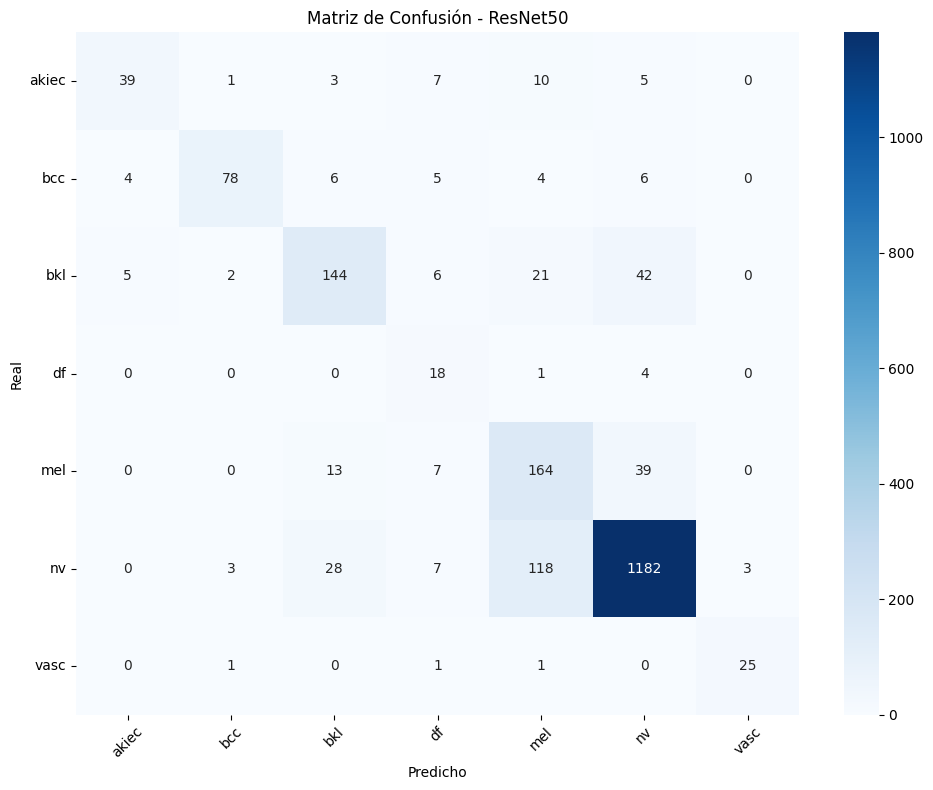

In [ ]:
# 📊 Evaluación final en el conjunto de prueba
def evaluate_model(model, test_loader):
    """Evalúa un modelo en el conjunto de prueba y retorna métricas detalladas."""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluando el modelo'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

# 1. Obtener las predicciones y etiquetas del conjunto de prueba
# Asume que 'resnet_model' es la variable que contiene el modelo ya entrenado
true_labels, predictions, probabilities = evaluate_model(resnet_model, test_loader)

# 2. Generar el reporte de clasificación (con F1, Precisión, Recall)
report = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
print("--- Reporte de Clasificación Final ---")
print(report)

# 3. Calcular métricas macro (F1, Precisión, Recall)
report_dict = classification_report(true_labels, predictions, target_names=label_names, zero_division=0, output_dict=True)
print("\n--- Métricas Macro ---")
print(f"F1 Macro: {report_dict['macro avg']['f1-score']:.4f}")
print(f"Precision Macro: {report_dict['macro avg']['precision']:.4f}")
print(f"Recall Macro: {report_dict['macro avg']['recall']:.4f}")

# 4. Calcular ROC-AUC Macro
try:
    true_labels_bin = label_binarize(true_labels, classes=range(len(label_names)))
    roc_auc_macro = roc_auc_score(true_labels_bin, probabilities, average='macro', multi_class='ovr')
    print(f"ROC-AUC Macro: {roc_auc_macro:.4f}")
except ValueError as e:
    print(f"Error al calcular ROC-AUC: {e}. Puede que falten clases en el conjunto de prueba.")

# 5. Generar y visualizar la matriz de confusión
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusión - ResNet50')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##efficientnetb0

Evaluando el modelo:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789cc8d5a020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

--- Reporte de Clasificación Final ---
              precision    recall  f1-score   support

       akiec       0.57      0.80      0.67        65
         bcc       0.54      0.92      0.68       103
         bkl       0.84      0.64      0.72       220
          df       1.00      0.83      0.90        23
         mel       0.75      0.65      0.70       223
          nv       0.94      0.93      0.94      1341
        vasc       0.96      0.79      0.86        28

    accuracy                           0.86      2003
   macro avg       0.80      0.79      0.78      2003
weighted avg       0.87      0.86      0.86      2003


--- Métricas Macro ---
F1 Macro: 0.7817
Precision Macro: 0.7992
Recall Macro: 0.7934
ROC-AUC Macro: 0.9694


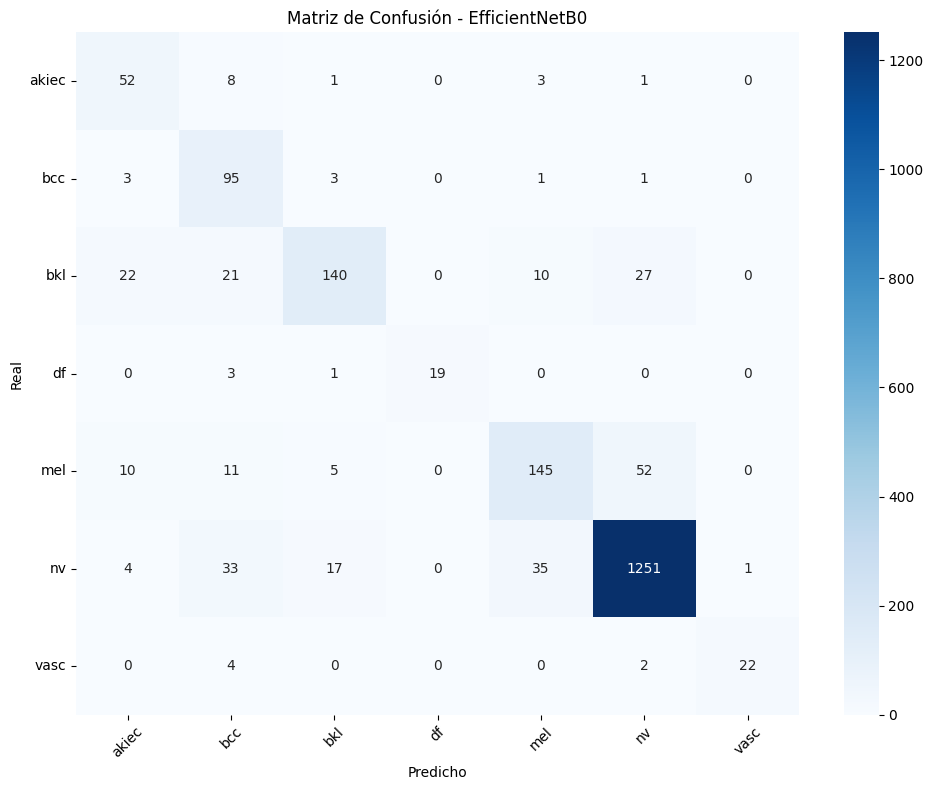

In [ ]:
# 📊 Evaluación final en el conjunto de prueba
def evaluate_model(model, test_loader):
    """Evalúa un modelo en el conjunto de prueba y retorna métricas detalladas."""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluando el modelo'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

# 1. Obtener las predicciones y etiquetas del conjunto de prueba
# Asume que 'efficientnet_model' es la variable que contiene el modelo ya entrenado
true_labels, predictions, probabilities = evaluate_model(efficientnet_model, test_loader)

# 2. Generar el reporte de clasificación (con F1, Precisión, Recall)
report = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
print("--- Reporte de Clasificación Final ---")
print(report)

# 3. Calcular métricas macro (F1, Precisión, Recall)
report_dict = classification_report(true_labels, predictions, target_names=label_names, zero_division=0, output_dict=True)
print("\n--- Métricas Macro ---")
print(f"F1 Macro: {report_dict['macro avg']['f1-score']:.4f}")
print(f"Precision Macro: {report_dict['macro avg']['precision']:.4f}")
print(f"Recall Macro: {report_dict['macro avg']['recall']:.4f}")

# 4. Calcular ROC-AUC Macro
try:
    true_labels_bin = label_binarize(true_labels, classes=range(len(label_names)))
    roc_auc_macro = roc_auc_score(true_labels_bin, probabilities, average='macro', multi_class='ovr')
    print(f"ROC-AUC Macro: {roc_auc_macro:.4f}")
except ValueError as e:
    print(f"Error al calcular ROC-AUC: {e}. Puede que falten clases en el conjunto de prueba.")

# 5. Generar y visualizar la matriz de confusión
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusión - EfficientNetB0')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##MobileNetV2

Evaluando el modelo:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e217cd35f80>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e217cd35f80>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():
 self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
      ^ ^ ^^ ^ ^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^^ ^ ^
   File "/usr/lib/py

--- Reporte de Clasificación Final ---
              precision    recall  f1-score   support

       akiec       0.70      0.77      0.74        65
         bcc       0.88      0.85      0.87       103
         bkl       0.85      0.64      0.73       220
          df       0.82      0.78      0.80        23
         mel       0.64      0.61      0.63       223
          nv       0.91      0.93      0.92      1341
        vasc       0.58      1.00      0.74        28

    accuracy                           0.86      2003
   macro avg       0.77      0.80      0.77      2003
weighted avg       0.86      0.86      0.85      2003


--- Métricas Macro ---
F1 Macro: 0.7739
Precision Macro: 0.7689
Recall Macro: 0.7994
ROC-AUC Macro: 0.9714


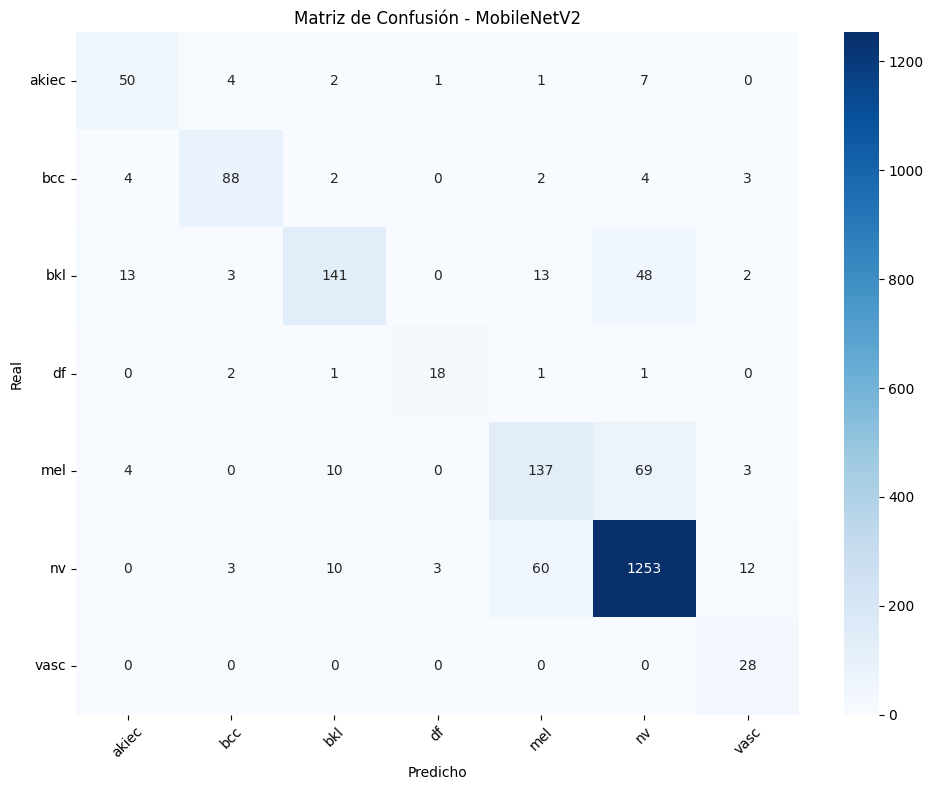

In [ ]:
# 📊 Evaluación final en el conjunto de prueba
def evaluate_model(model, test_loader):
    """Evalúa un modelo en el conjunto de prueba y retorna métricas detalladas."""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluando el modelo'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

# 1. Obtener las predicciones y etiquetas del conjunto de prueba
# Asume que 'mobilenet_model' es la variable que contiene el modelo ya entrenado
true_labels, predictions, probabilities = evaluate_model(mobilenet_model, test_loader)

# 2. Generar el reporte de clasificación (con F1, Precisión, Recall)
report = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
print("--- Reporte de Clasificación Final ---")
print(report)

# 3. Calcular métricas macro (F1, Precisión, Recall)
report_dict = classification_report(true_labels, predictions, target_names=label_names, zero_division=0, output_dict=True)
print("\n--- Métricas Macro ---")
print(f"F1 Macro: {report_dict['macro avg']['f1-score']:.4f}")
print(f"Precision Macro: {report_dict['macro avg']['precision']:.4f}")
print(f"Recall Macro: {report_dict['macro avg']['recall']:.4f}")

# 4. Calcular ROC-AUC Macro
try:
    true_labels_bin = label_binarize(true_labels, classes=range(len(label_names)))
    roc_auc_macro = roc_auc_score(true_labels_bin, probabilities, average='macro', multi_class='ovr')
    print(f"ROC-AUC Macro: {roc_auc_macro:.4f}")
except ValueError as e:
    print(f"Error al calcular ROC-AUC: {e}. Puede que falten clases en el conjunto de prueba.")

# 5. Generar y visualizar la matriz de confusión
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusión - MobileNetV2')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## General

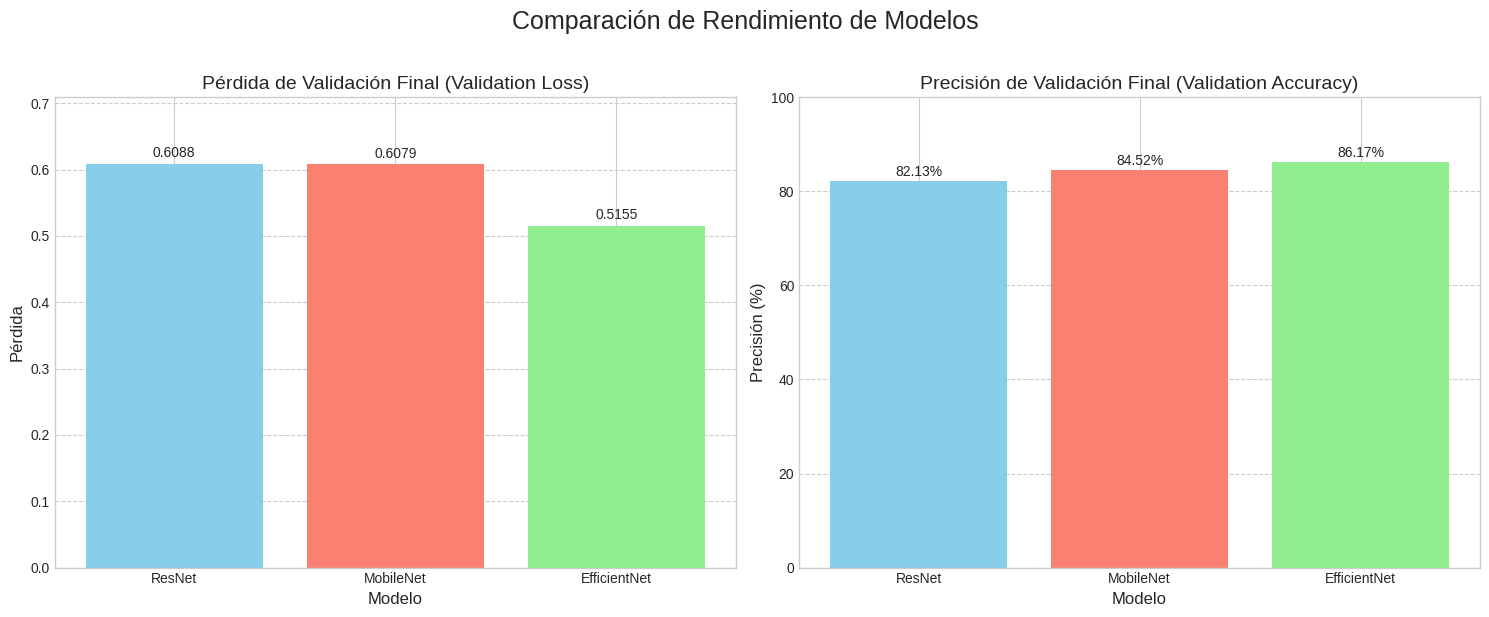

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos finales de los modelos (usando el mejor resultado de validación)
models = ['ResNet', 'MobileNet', 'EfficientNet']

# Pérdida de validación final (validation_loss)
validation_loss = [0.6088, 0.6079, 0.5155]

# Precisión de validación final (validation_accuracy)
validation_accuracy = [82.13, 84.52, 86.17]

# Configuración del estilo
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ----- Gráfico 1: Comparación de Pérdida de Validación (Validation Loss) -----
colors_loss = ['skyblue', 'salmon', 'lightgreen']
ax1.bar(models, validation_loss, color=colors_loss)
ax1.set_title('Pérdida de Validación Final (Validation Loss)', fontsize=14)
ax1.set_xlabel('Modelo', fontsize=12)
ax1.set_ylabel('Pérdida', fontsize=12)
ax1.set_ylim(0, max(validation_loss) + 0.1) # Ajuste automático del límite superior
ax1.grid(axis='y', linestyle='--')

# Añadir los valores en la parte superior de cada barra
for i, v in enumerate(validation_loss):
    ax1.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=10)


# ----- Gráfico 2: Comparación de Precisión de Validación (Validation Accuracy) -----
colors_accuracy = ['skyblue', 'salmon', 'lightgreen']
ax2.bar(models, validation_accuracy, color=colors_accuracy)
ax2.set_title('Precisión de Validación Final (Validation Accuracy)', fontsize=14)
ax2.set_xlabel('Modelo', fontsize=12)
ax2.set_ylabel('Precisión (%)', fontsize=12)
ax2.set_ylim(0, 100) # El rango va de 0 a 100 para una visión completa
ax2.grid(axis='y', linestyle='--')

# Añadir los valores en la parte superior de cada barra
for i, v in enumerate(validation_accuracy):
    ax2.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparación de Rendimiento de Modelos', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# ------------ Inferencia de ejemplo ------------


##ResNet50

--- INFERENCIA CON MÚLTIPLES IMÁGENES ---


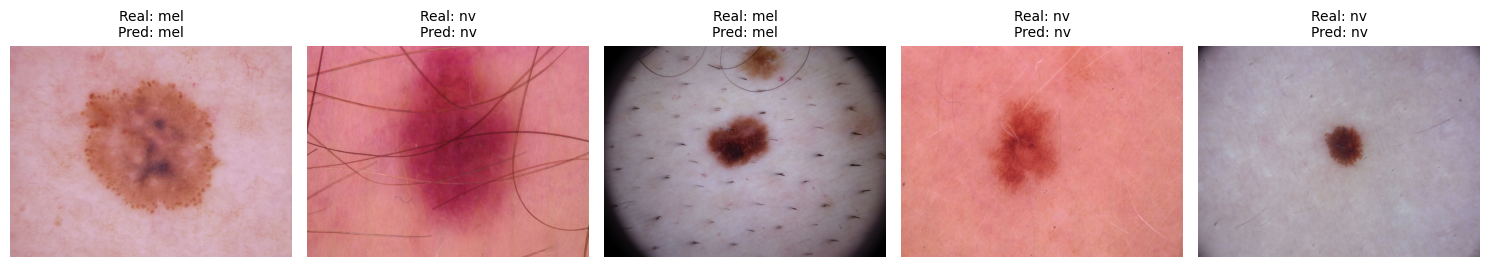

✅ Inferencia completada para las imágenes de prueba.


In [ ]:
# 💡 Inferencia de ejemplo con múltiples imágenes
print("--- INFERENCIA CON MÚLTIPLES IMÁGENES ---")

# Seleccionar 5 imágenes aleatorias del conjunto de prueba
num_samples = 5
sample_rows = test_df.sample(n=num_samples, random_state=random.randint(0, 100))

# Asegurar que el modelo esté en modo de evaluación
# La variable 'resnet_model' ya debe estar entrenada desde una celda anterior
resnet_model.eval()

# Iterar sobre cada muestra y realizar la inferencia
plt.figure(figsize=(15, 12))
for i, (index, row) in enumerate(sample_rows.iterrows()):
    sample_path = row['path']
    sample_label = row['dx']

    # Preprocesar la imagen
    sample_image = Image.open(sample_path).convert('RGB')
    input_tensor = val_transform(sample_image).unsqueeze(0).to(device)

    # Realizar la predicción
    with torch.no_grad():
        output = resnet_model(input_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_names[predicted_idx.item()]

    # Mostrar el resultado en un subplot
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Real: {sample_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Inferencia completada para las imágenes de prueba.")

##efficientnetb0

--- INFERENCIA CON MÚLTIPLES IMÁGENES ---


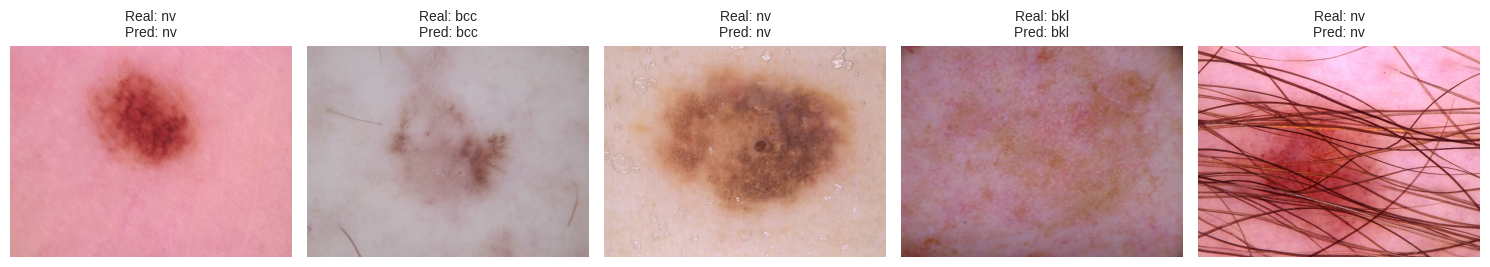

✅ Inferencia completada para las imágenes de prueba.


In [ ]:
# 💡 Inferencia de ejemplo con múltiples imágenes
print("--- INFERENCIA CON MÚLTIPLES IMÁGENES ---")

# Seleccionar 5 imágenes aleatorias del conjunto de prueba
num_samples = 5
sample_rows = test_df.sample(n=num_samples, random_state=random.randint(0, 100))

# Asegurar que el modelo esté en modo de evaluación
# La variable 'efficientnet_model' ya debe estar entrenada desde una celda anterior
efficientnet_model.eval()

# Iterar sobre cada muestra y realizar la inferencia
plt.figure(figsize=(15, 12))
for i, (index, row) in enumerate(sample_rows.iterrows()):
    sample_path = row['path']
    sample_label = row['dx']

    # Preprocesar la imagen
    sample_image = Image.open(sample_path).convert('RGB')
    input_tensor = val_transform(sample_image).unsqueeze(0).to(device)

    # Realizar la predicción
    with torch.no_grad():
        output = efficientnet_model(input_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_names[predicted_idx.item()]

    # Mostrar el resultado en un subplot
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Real: {sample_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Inferencia completada para las imágenes de prueba.")

##MobileNetV2

--- INFERENCIA CON MÚLTIPLES IMÁGENES ---


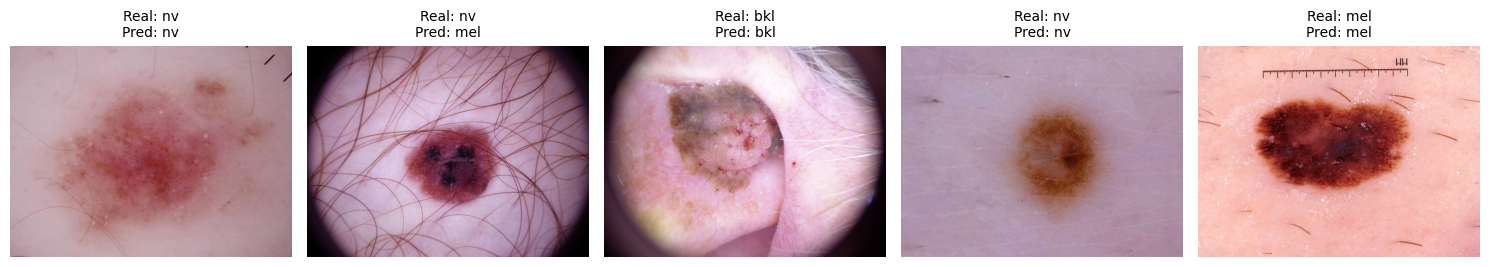

✅ Inferencia completada para las imágenes de prueba.


In [ ]:
# 💡 Inferencia de ejemplo con múltiples imágenes
print("--- INFERENCIA CON MÚLTIPLES IMÁGENES ---")

# Seleccionar 5 imágenes aleatorias del conjunto de prueba
num_samples = 5
sample_rows = test_df.sample(n=num_samples, random_state=random.randint(0, 100))

# Asegurar que el modelo esté en modo de evaluación
mobilenet_model.eval()

# Iterar sobre cada muestra y realizar la inferencia
plt.figure(figsize=(15, 12))
for i, (index, row) in enumerate(sample_rows.iterrows()):
    sample_path = row['path']
    sample_label = row['dx']

    # Preprocesar la imagen
    sample_image = Image.open(sample_path).convert('RGB')
    input_tensor = val_transform(sample_image).unsqueeze(0).to(device)

    # Realizar la predicción
    with torch.no_grad():
        output = mobilenet_model(input_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_names[predicted_idx.item()]

    # Mostrar el resultado en un subplot
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Real: {sample_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Inferencia completada para las imágenes de prueba.")

# ------------ Guardado de resultados ------------

##ResNet50

In [17]:
# 💾 Proceso completo de evaluación y guardado de resultados

# Asegúrate de que las siguientes variables estén definidas
# - 'model_name': el nombre del modelo (ej. 'ResNet50')
# - 'resnet_model': tu modelo entrenado
# - 'df': el DataFrame con las métricas de entrenamiento (pérdida, precisión)
# - 'true_labels', 'predictions': las etiquetas reales y predichas de la evaluación final
# - 'test_df': el DataFrame del conjunto de prueba para la inferencia
# - 'val_transform': las transformaciones de validación/prueba

# 1. Crear el directorio 'results' si no existe
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
print(f"✅ Directorio '{results_dir}' creado o ya existente.")

# 2. Guardar el DataFrame con las métricas de entrenamiento
df.to_csv(os.path.join(results_dir, f'training_metrics_{model_name}.csv'), index=False)
print(f"✅ DataFrame de métricas de entrenamiento guardado para {model_name}.")

# 3. Guardar los gráficos de pérdida y precisión
plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico de Pérdida (Loss)
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['loss'], label='Pérdida de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_loss'], label='Pérdida de Validación', marker='x')
plt.title(f'Pérdida de Entrenamiento y Validación - {model_name}', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.savefig(os.path.join(results_dir, f'loss_plot_{model_name}.png'))
plt.close()
print(f"✅ Gráfico de pérdida guardado para {model_name}.")

# Gráfico de Precisión (Accuracy)
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['accuracy'], label='Precisión de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_accuracy'], label='Precisión de Validación', marker='x')
plt.title(f'Precisión de Entrenamiento y Validación - {model_name}', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.savefig(os.path.join(results_dir, f'accuracy_plot_{model_name}.png'))
plt.close()
print(f"✅ Gráfico de precisión guardado para {model_name}.")

# 4. Generar y guardar el reporte de clasificación y la matriz de confusión
report_text = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
file_path_report = os.path.join(results_dir, f'classification_report_{model_name}.txt')
with open(file_path_report, 'w') as f:
    f.write(report_text)
print(f"✅ Reporte de clasificación guardado en: {file_path_report}")

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title(f'Matriz de Confusión - {model_name}')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
file_path_cm = os.path.join(results_dir, f'confusion_matrix_{model_name}.png')
plt.savefig(file_path_cm)
plt.close()
print(f"✅ Matriz de confusión guardada en: {file_path_cm}")

# 5. Generar y guardar el gráfico de inferencia de ejemplo
print("\n--- Generando y guardando gráfico de inferencia ---")
num_samples = 5
sample_rows = test_df.sample(n=num_samples, random_state=random.randint(0, 100))
resnet_model.eval()

plt.figure(figsize=(15, 12))
for i, (index, row) in enumerate(sample_rows.iterrows()):
    sample_path = row['path']
    sample_label = row['dx']
    sample_image = Image.open(sample_path).convert('RGB')
    input_tensor = val_transform(sample_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = resnet_model(input_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_names[predicted_idx.item()]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Real: {sample_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
file_path_inference = os.path.join(results_dir, f'inference_examples_{model_name}.png')
plt.savefig(file_path_inference)
plt.close()
print(f"✅ Gráfico de inferencia guardado en: {file_path_inference}")

# 6. Guardar el modelo entrenado
file_path_model = os.path.join(results_dir, f'{model_name}_best.pth')
torch.save(resnet_model.state_dict(), file_path_model)
print(f"✅ Modelo entrenado guardado en: {file_path_model}")

print("\n🎉 Proceso de evaluación y guardado completado con éxito.")

✅ Directorio 'results' creado o ya existente.
✅ DataFrame de métricas de entrenamiento guardado para EfficientNetB0.
✅ Gráfico de pérdida guardado para EfficientNetB0.
✅ Gráfico de precisión guardado para EfficientNetB0.
✅ Reporte de clasificación guardado en: results/classification_report_EfficientNetB0.txt
✅ Matriz de confusión guardada en: results/confusion_matrix_EfficientNetB0.png

--- Generando y guardando gráfico de inferencia ---
✅ Gráfico de inferencia guardado en: results/inference_examples_EfficientNetB0.png
✅ Modelo entrenado guardado en: results/EfficientNetB0_best.pth

🎉 Proceso de evaluación y guardado completado con éxito.


##efficientnetb0

In [ ]:
# 💾 Proceso completo de evaluación y guardado de resultados para EfficientNetB0

# Asegúrate de que las siguientes variables estén definidas en celdas anteriores:
# - 'efficientnet_model': tu modelo EfficientNetB0 entrenado
# - 'true_labels', 'predictions': las etiquetas reales y predichas de la evaluación final
# - 'test_df': el DataFrame del conjunto de prueba para la inferencia
# - 'val_transform': las transformaciones de validación/prueba
# - 'label_names': la lista de nombres de las clases
# - 'device': el dispositivo de computación (GPU/CPU)

# Datos de entrenamiento extraídos de la salida de entrenamiento
training_loss = [0.5316, 0.2465, 0.1668, 0.1290, 0.1145, 0.1001, 0.0764, 0.0745, 0.0674, 0.0640, 0.0567]
training_accuracy = [80.48, 90.94, 93.88, 95.40, 95.98, 96.47, 97.38, 97.47, 97.67, 97.69, 97.98]
validation_loss = [0.6273, 0.5603, 0.6093, 0.6132, 0.6254, 0.5155, 0.5888, 0.6085, 0.6325, 0.7171, 0.7605]
validation_accuracy = [75.24, 80.93, 80.58, 85.12, 84.82, 86.17, 86.07, 83.62, 86.22, 82.98, 84.97]
model_name = 'EfficientNetB0'

# 1. Crear el directorio 'results' si no existe
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
print(f"✅ Directorio '{results_dir}' creado o ya existente.")

# 2. Guardar las métricas de entrenamiento en un DataFrame y un archivo CSV
epochs = range(1, len(training_loss) + 1)
data = {
    'epochs': epochs,
    'loss': training_loss,
    'accuracy': training_accuracy,
    'val_loss': validation_loss,
    'val_accuracy': validation_accuracy
}
df = pd.DataFrame(data)
df.to_csv(os.path.join(results_dir, f'training_metrics_{model_name}.csv'), index=False)
print(f"✅ DataFrame de métricas de entrenamiento guardado para {model_name}.")

# 3. Guardar los gráficos de pérdida y precisión
plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico de Pérdida (Loss)
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['loss'], label='Pérdida de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_loss'], label='Pérdida de Validación', marker='x')
plt.title(f'Pérdida de Entrenamiento y Validación - {model_name}', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.savefig(os.path.join(results_dir, f'loss_plot_{model_name}.png'))
plt.close()
print(f"✅ Gráfico de pérdida guardado para {model_name}.")

# Gráfico de Precisión (Accuracy)
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['accuracy'], label='Precisión de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_accuracy'], label='Precisión de Validación', marker='x')
plt.title(f'Precisión de Entrenamiento y Validación - {model_name}', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.savefig(os.path.join(results_dir, f'accuracy_plot_{model_name}.png'))
plt.close()
print(f"✅ Gráfico de precisión guardado para {model_name}.")

# 4. Generar y guardar el reporte de clasificación y la matriz de confusión
report_text = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
file_path_report = os.path.join(results_dir, f'classification_report_{model_name}.txt')
with open(file_path_report, 'w') as f:
    f.write(report_text)
print(f"✅ Reporte de clasificación guardado en: {file_path_report}")

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title(f'Matriz de Confusión - {model_name}')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
file_path_cm = os.path.join(results_dir, f'confusion_matrix_{model_name}.png')
plt.savefig(file_path_cm)
plt.close()
print(f"✅ Matriz de confusión guardada en: {file_path_cm}")

# 5. Generar y guardar el gráfico de inferencia de ejemplo
print("\n--- Generando y guardando gráfico de inferencia ---")
num_samples = 5
sample_rows = test_df.sample(n=num_samples, random_state=random.randint(0, 100))
efficientnet_model.eval()

plt.figure(figsize=(15, 12))
for i, (index, row) in enumerate(sample_rows.iterrows()):
    sample_path = row['path']
    sample_label = row['dx']
    sample_image = Image.open(sample_path).convert('RGB')
    input_tensor = val_transform(sample_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = efficientnet_model(input_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_names[predicted_idx.item()]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Real: {sample_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
file_path_inference = os.path.join(results_dir, f'inference_examples_{model_name}.png')
plt.savefig(file_path_inference)
plt.close()
print(f"✅ Gráfico de inferencia guardado en: {file_path_inference}")

# 6. Guardar el modelo entrenado
file_path_model = os.path.join(results_dir, f'{model_name.lower()}_best.pth')
torch.save(efficientnet_model.state_dict(), file_path_model)
print(f"✅ Modelo entrenado guardado en: {file_path_model}")

print("\n🎉 Proceso de evaluación y guardado completado con éxito.")

✅ Directorio 'results' creado o ya existente.
✅ DataFrame de métricas de entrenamiento guardado para EfficientNetB0.
✅ Gráfico de pérdida guardado para EfficientNetB0.
✅ Gráfico de precisión guardado para EfficientNetB0.
✅ Reporte de clasificación guardado en: results/classification_report_EfficientNetB0.txt
✅ Matriz de confusión guardada en: results/confusion_matrix_EfficientNetB0.png

--- Generando y guardando gráfico de inferencia ---
✅ Gráfico de inferencia guardado en: results/inference_examples_EfficientNetB0.png
✅ Modelo entrenado guardado en: results/efficientnetb0_best.pth

🎉 Proceso de evaluación y guardado completado con éxito.


##MobileNetV2

In [ ]:
# 💾 Proceso completo de evaluación y guardado de resultados para MobileNetV2

# Asegúrate de que las siguientes variables estén definidas:
# - 'model_name': 'mobilenetv2'
# - 'mobilenet_model': tu modelo MobileNetV2 entrenado
# - 'true_labels', 'predictions': las etiquetas reales y predichas de la evaluación final
# - 'test_df': el DataFrame del conjunto de prueba para la inferencia
# - 'val_transform': las transformaciones de validación/prueba
# - 'training_loss', 'training_accuracy', 'validation_loss', 'validation_accuracy': las listas de métricas de entrenamiento

# 1. Crear el directorio 'results' si no existe
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
print(f"✅ Directorio '{results_dir}' creado o ya existente.")

# 2. Guardar las métricas de entrenamiento en un DataFrame y un archivo CSV
data = {
    'epochs': range(1, len(training_loss) + 1),
    'loss': training_loss,
    'accuracy': training_accuracy,
    'val_loss': validation_loss,
    'val_accuracy': validation_accuracy
}
df = pd.DataFrame(data)
df.to_csv(os.path.join(results_dir, 'training_metrics_mobilenetv2.csv'), index=False)
print("✅ DataFrame de métricas de entrenamiento guardado.")

# 3. Guardar los gráficos de pérdida y precisión
plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico de Pérdida (Loss)
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['loss'], label='Pérdida de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_loss'], label='Pérdida de Validación', marker='x')
plt.title('Pérdida de Entrenamiento y Validación - MobileNetV2', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'loss_plot_mobilenetv2.png'))
plt.close()
print("✅ Gráfico de pérdida guardado.")

# Gráfico de Precisión (Accuracy)
plt.figure(figsize=(10, 6))
plt.plot(df['epochs'], df['accuracy'], label='Precisión de Entrenamiento', marker='o')
plt.plot(df['epochs'], df['val_accuracy'], label='Precisión de Validación', marker='x')
plt.title('Precisión de Entrenamiento y Validación - MobileNetV2', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.legend()
plt.xticks(df['epochs'])
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'accuracy_plot_mobilenetv2.png'))
plt.close()
print("✅ Gráfico de precisión guardado.")

# 4. Generar y guardar el reporte de clasificación y la matriz de confusión
report_text = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
file_path_report = os.path.join(results_dir, 'classification_report_mobilenetv2.txt')
with open(file_path_report, 'w') as f:
    f.write(report_text)
print(f"✅ Reporte de clasificación guardado en: {file_path_report}")

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusión - MobileNetV2')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
file_path_cm = os.path.join(results_dir, 'confusion_matrix_mobilenetv2.png')
plt.savefig(file_path_cm)
plt.close()
print(f"✅ Matriz de confusión guardada en: {file_path_cm}")

# 5. Generar y guardar el gráfico de inferencia de ejemplo
print("\n--- Generando y guardando gráfico de inferencia ---")
num_samples = 5
sample_rows = test_df.sample(n=num_samples, random_state=random.randint(0, 100))
mobilenet_model.eval()

plt.figure(figsize=(15, 12))
for i, (index, row) in enumerate(sample_rows.iterrows()):
    sample_path = row['path']
    sample_label = row['dx']
    sample_image = Image.open(sample_path).convert('RGB')
    input_tensor = val_transform(sample_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = mobilenet_model(input_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = label_names[predicted_idx.item()]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Real: {sample_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
file_path_inference = os.path.join(results_dir, 'inference_examples_mobilenetv2.png')
plt.savefig(file_path_inference)
plt.close()
print(f"✅ Gráfico de inferencia guardado en: {file_path_inference}")

# 6. Guardar el modelo entrenado
file_path_model = os.path.join(results_dir, 'mobilenetv2_best.pth')
torch.save(mobilenet_model.state_dict(), file_path_model)
print(f"✅ Modelo entrenado guardado en: {file_path_model}")

print("\n🎉 Proceso de evaluación y guardado completado con éxito.")

✅ Directorio 'results' creado o ya existente.
✅ DataFrame de métricas de entrenamiento guardado.
✅ Gráfico de pérdida guardado.
✅ Gráfico de precisión guardado.
✅ Reporte de clasificación guardado en: results/classification_report_mobilenetv2.txt
✅ Matriz de confusión guardada en: results/confusion_matrix_mobilenetv2.png

--- Generando y guardando gráfico de inferencia ---
✅ Gráfico de inferencia guardado en: results/inference_examples_mobilenetv2.png
✅ Modelo entrenado guardado en: results/mobilenetv2_best.pth

🎉 Proceso de evaluación y guardado completado con éxito.
